In [4]:
import matplotlib.pyplot as plt
import product_fem as pf
import numpy as np
from fenics import plot, refine, Point
from mshr import Circle

## Meshes API
There are two ways to construct a mesh.
1. use prebuilt mesh functions
2. use mesh geometries to form a new mesh

The former can be done by any of the `pf.*_mesh` functions,
while the latter uses `pf.*_geom` functions, followed by
`pf.generate_mesh`

### Rectangular shaped meshes

One of the simplest meshes we can make are those
in the shape of a rectangle. Below we show how to construct such a mesh, starting with the special
case of the unit square.

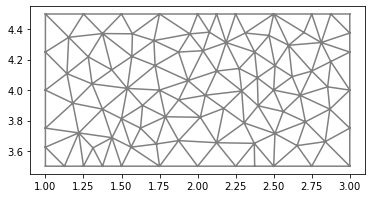

In [11]:
mesh = pf.rectangle_mesh(resolution=8, 
                         width=2, 
                         height=1,
                         center=[2,4])
plot(mesh);

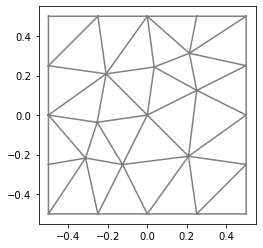

In [10]:
mesh = pf.unit_square_mesh(resolution=3.5)
plot(mesh);

We can also choose to rotate a mesh by using the `angle` argument, which defaults to 0.

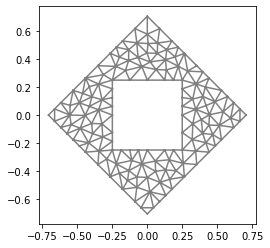

In [7]:
diamond = pf.unit_square_geom(center=[0,0], angle=np.pi/4)
square = pf.square_geom(0.5, center=[0,0])
mesh_geom = diamond - square
mesh = pf.generate_mesh(mesh_geom, 10)
plot(mesh);

### Elliptical shaped meshes
In addition to rectangular meshes we also have ellipse shaped meshes.
To create an ellipse we must specify the horizontal semi-axis length,
the vertical semi-axis length. Optionally we can provide the ellipse center, number of segments on the circumference, and the angle to rotate.

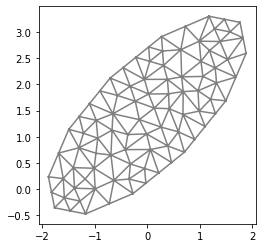

In [12]:
mesh = pf.ellipse_mesh(resolution=8, 
                       x_semi=2.5, 
                       y_semi=1, 
                       center=[1,1], 
                       segments=12, 
                       angle=np.pi/4)
plot(mesh);

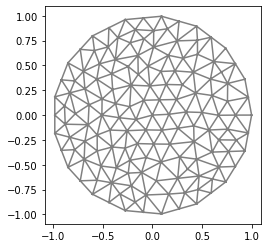

In [13]:
# naturally, discs don't need a rotation angle
mesh = pf.unit_disc_mesh(resolution=8)
plot(mesh);

### Derived meshes

In [14]:
def annulus_geom(R, r):
    """Create annulus shaped mesh with inner/outer radii r/R, resp."""
    big_disc = pf.disc_geom(center=[0,0], radius=R, segments=12)
    lil_disc = pf.disc_geom(center=[0,0], radius=r, segments=12)
    geom = big_disc - lil_disc
    return geom

def annulus_mesh(resolution, R, r):
    geom = annulus_geom(R, r)
    return pf.generate_mesh(geom, resolution)

def crescent_moon_geom():
    full_moon = pf.unit_disc_geom()
    dark_side = pf.disc_geom(center=[0.6, 0], radius=0.5, segments=12)
    geom = full_moon - dark_side
    return geom

def crescent_moon_mesh(resolution):
    geom = crescent_moon_geom()
    return pf.generate_mesh(geom, resolution)

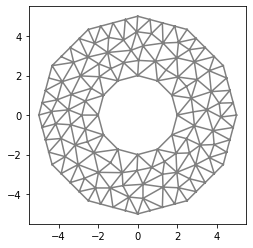

In [15]:
annulus = annulus_mesh(resolution=8, R=5, r=2)
plot(annulus);

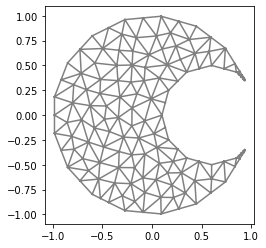

In [16]:
crescent = crescent_moon_mesh(resolution=8)
plot(crescent);

### Polygonal shaped meshes
Finally, we can create meshes of arbitrary shape given
the vertices of the polynomial boundary. The only catch
is the vertices need to be sorted in counterclockwise order.

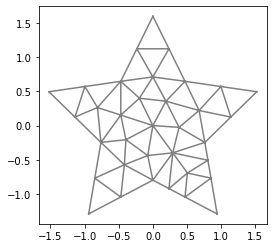

In [17]:
n = 10
r, R = 0.8, 1.6
angle = -np.pi/n
res = 5

weights = np.array(n * [[r, r]])
mask = (np.arange(n)[:, np.newaxis] + np.zeros(2, dtype=int)) % 2
weights -= mask * np.array([r, r])
weights += mask * np.array([R, R])

def roots_of_unity(n):
    # the kth root is x + iy where (x, y) = 
    # (w[k,0] cos(2pi k/n), w[k,1] sin(2pi k/n))
    roots = np.array([[np.cos(2*np.pi * k/n), 
                       np.sin(2*np.pi * k/n)] for k in range(n)])
    return roots

vertices = roots_of_unity(n)
vertices *= weights
mesh = pf.polygon_mesh(res, vertices, angle)
plot(mesh);

Another way we can make a polynomial mesh from a collection of
points, not necessarily in counterclockwise order, we can
simply create a convex hull of those points.

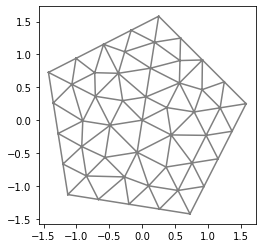

In [18]:
mesh = pf.convex_hull_mesh(res, vertices, angle=np.pi/4)
plot(mesh);

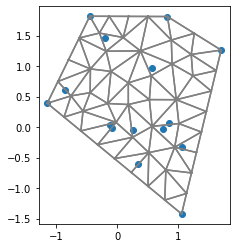

In [19]:
vertices = np.random.randn(2*15).reshape(15,2)
hull = pf.convex_hull_mesh(res, vertices)

fig, ax = plt.subplots()
lines = plot(hull)
for line in lines:
    ax.add_line(line)
ax.scatter(vertices[:,0], vertices[:,1])
plt.show()

### Local Refinement
The following example was taken from https://anders.logg.org/2016/06/02/mesh-generation-in-fenics/

Basically, we can define subdomains in arbitrary regions and the
mesh will have local refinement where the subdomains overlap.

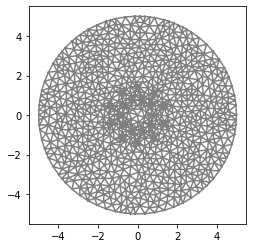

In [20]:
a = 1.0   # inner radius of iron cylinder
b = 1.2   # outer radius of iron cylinder
c_1 = 0.8 # radius for inner circle of copper wires
c_2 = 1.4 # radius for outer circle of copper wires
r = 0.1   # radius of copper wires
R = 5.0   # radius of domain
n = 10    # number of windings

# Define geometry for background
domain = Circle(Point(0, 0), R)

# Define geometry for iron cylinder
cylinder = Circle(Point(0, 0), b) - Circle(Point(0, 0), a)

# Define geometry for wires (N = North (up), S = South (down))
angles_N = [i*2*np.pi/n for i in range(n)]
angles_S = [(i + 0.5)*2*np.pi/n for i in range(n)]
wires_N = [Circle(Point(c_1*np.cos(v), c_1*np.sin(v)), r) for v in angles_N]
wires_S = [Circle(Point(c_2*np.cos(v), c_2*np.sin(v)), r) for v in angles_S]

# Set subdomain for iron cylinder
domain.set_subdomain(1, cylinder)

# Set subdomains for wires
for (i, wire) in enumerate(wires_N):
    domain.set_subdomain(2 + i, wire)
for (i, wire) in enumerate(wires_S):
    domain.set_subdomain(2 + n + i, wire)

# Create mesh
mesh = pf.generate_mesh(domain, 20)
plot(mesh);

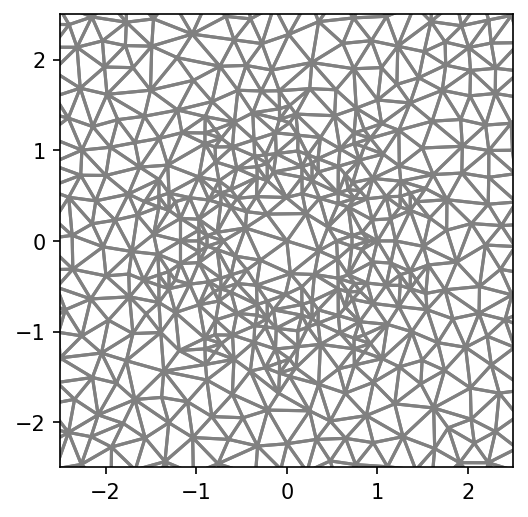

In [21]:
fig, ax = plt.subplots(dpi=150)
lines = plot(mesh)

for line in lines:
    ax.add_line(line)
    
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
plt.show()